In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as utils
from torchvision.utils import save_image
from frechet_distance_cal import calculate_fretchet
from torchvision import models
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.embed = nn.Embedding(num_classes, embed_size)

        self.initial_layer = nn.Sequential(
            nn.ConvTranspose2d(channels_noise + embed_size, features_g * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(True)
        )

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(features_g * 16, features_g * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True)
        )
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        embedding = self.embed(labels).view(-1, self.embed.embedding_dim, 1, 1)
        embedding = embedding.expand(-1, -1, noise.size(2), noise.size(3))  # Expand to match noise dimensions

        gen_input = torch.cat([noise, embedding], dim=1)
        
        out = self.initial_layer(gen_input)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        img = self.final_layer(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        # Define the convolutional layers directly in the constructor
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        # Output layers for validity (real or fake) and class labels
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        self.label_layer = nn.Sequential(
            nn.Conv2d(512, num_classes+1, 4, 1, 0, bias=False),
            nn.LogSoftmax(dim=1)
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def forward(self, x):
        x = self.disc(x)
        validity = self.validity_layer(x).view(-1)
        label = self.label_layer(x).view(-1, num_classes+1)
        return validity, label

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_and_save_graph(gen_loss, dis_loss, fretchet_distances, out_path, epochs):
    import matplotlib.pyplot as plt
    import os
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(gen_loss, label="Generator")
    plt.plot(dis_loss, label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss During Training")

    plt.subplot(2, 1, 2)
    plt.plot(fretchet_distances, label="FID for DCGAN")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.legend()
    plt.title("FID Scores for DCGAN")

    plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

In [3]:
num_classes = 10
nz = 100
ngf = 64
ndf = 64
nc = 3
batch_size = 128
lr = 2e-4
beta1 = 0.5
epochs = 40
img_size = 64
embed_size = nz  # Embedding size same as noise dimension for simplicity
G_losses = list()
D_losses = list()
img_list = list()
fretchet_distances = list()

# Datasets and DataLoader
tf = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Initialize models
netG = Generator(num_classes, img_size, embed_size, nz, nc, ngf).to(device)
netD = Discriminator(num_classes, img_size, nc, ndf).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# Fixed noise for visualizing the progress of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (32,), device=device)

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.NLLLoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Output directory for results
out_path = 'ACGaN_Out_40'
os.makedirs(out_path, exist_ok=True)

Files already downloaded and verified


In [7]:
netG.train(), netD.train()

(Generator(
   (embed): Embedding(10, 100)
   (initial_layer): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv1): Sequential(
     (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv2): Sequential(
     (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv3): Sequential(
     (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


End of epoch 1 / 40 	 Loss D: 1.4605 	 Loss G: 2.4510 	 FID: 407.1621
End of epoch 6 / 40 	 Loss D: 0.7184 	 Loss G: 2.1696 	 FID: 332.9067
End of epoch 11 / 40 	 Loss D: 0.7940 	 Loss G: 4.9692 	 FID: 279.2736
End of epoch 16 / 40 	 Loss D: 0.4007 	 Loss G: 3.6990 	 FID: 288.4030
End of epoch 21 / 40 	 Loss D: 0.2421 	 Loss G: 5.4585 	 FID: 285.6531
End of epoch 26 / 40 	 Loss D: 0.3512 	 Loss G: 7.6981 	 FID: 281.7285
End of epoch 31 / 40 	 Loss D: 0.2958 	 Loss G: 5.1930 	 FID: 338.0641
End of epoch 36 / 40 	 Loss D: 0.1982 	 Loss G: 5.3706 	 FID: 271.6230
Training has finished.


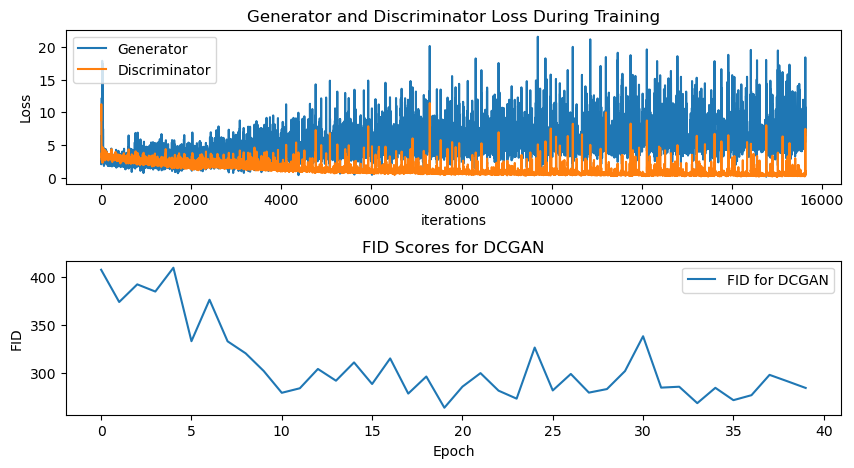

In [4]:
for epoch in range(epochs):
    for i, (data, labels) in enumerate(dataloader):
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        real_labels = labels.to(device)

        netD.zero_grad()
        label = torch.full((b_size,), 1., device=device)
        output, aux_output = netD(real_cpu)
        errD_real = adversarial_loss(output, label) + auxiliary_loss(aux_output, real_labels)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
        fake = netG(noise, fake_labels)
        label.fill_(0.)
        output, aux_output = netD(fake.detach())
        errD_fake = adversarial_loss(output, label) + auxiliary_loss(aux_output, fake_labels)
        errD_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output, aux_output = netD(fake)
        errG = adversarial_loss(output, label) + auxiliary_loss(aux_output, fake_labels)
        errG.backward()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item())

        # Check generator's progress by saving G's output on fixed noise
        if (i % 500 == 0) or (epoch == epochs-1 and i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            save_image(fake, f"{out_path}/fake_samples_epoch_{epoch}_{i}.png", normalize=True)

    # Calculate Frechet Distance every epoch and print the progress
    with torch.no_grad():
        fake_images = netG(fixed_noise, fixed_labels).detach()
    fretchet_dist = calculate_fretchet(real_cpu.cpu(), fake_images.cpu())
    fretchet_distances.append(fretchet_dist)
    if epoch%5==0:
        print(f'End of epoch {epoch+1} / {epochs} \t Loss D: {(errD_real+errD_fake).item()/2:.4f} \t Loss G: {errG.item():.4f} \t FID: {fretchet_dist:.4f}')
    
    images = netG(noise, fake_labels)
    image_fake_path = out_path+'/fake_samples_epoch_%03d.png' % epoch
    image_real_path = out_path+'/real_samples_epoch_%03d.png' % epoch
    utils.save_image(images.detach(),image_fake_path, normalize = True)
    utils.save_image(real_cpu.detach(),image_real_path, normalize = True)


with open(os.path.join(out_path, 'gen_error.txt'), 'w') as f:
    for line in G_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'dis_error.txt'), 'w') as f:
    for line in D_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'fretchet_distances.txt'), 'w') as f:
    for line in fretchet_distances:
        f.write(f"{line}\n")

plot_and_save_graph(G_losses, D_losses, fretchet_distances, out_path, epochs)
print('Training has finished.')

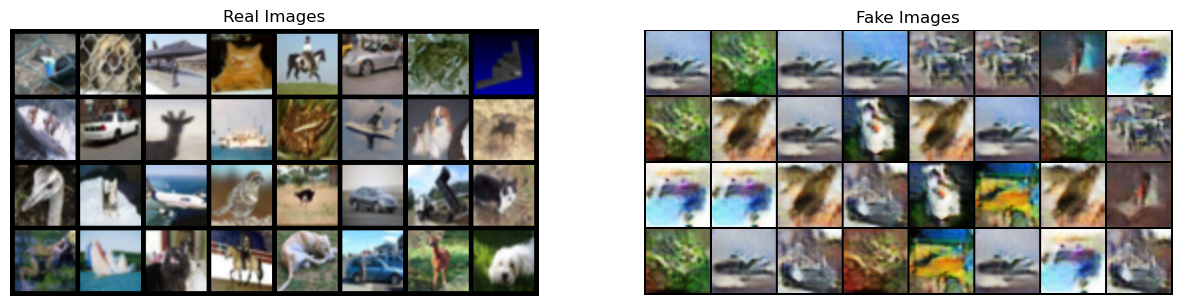

In [6]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('ACGaN_Out_40/ACGAN30_BEST_FAKE_32.png',
            format='png',
            bbox_inches='tight')
plt.show()